# 杭州二手房价的分析与预测

项目简介：使用scrapy框架爬取链家网上杭州二手房的基本数据，通过数据分析观察住房特征规律，利用机器学习模型进行简
单的预测。

技术和工具 本项目以Python语言编程完成从爬取，数据分析，到预测。

    爬虫工具：scrapy ，beautifulsoup
    数据分析：pandas，numpy，matplolib，seaborn
    机器学习：sklearn

数据初探

In [4]:
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif']=['SimHei']

In [37]:
#导入数据粗略观察一下
hangzhou_df = pd.read_csv("E:/hangzhou6.csv")
hangzhou_df.head()

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year
0,南 北,文一西路,无电梯,7,金成花园,103102194340,3室2厅,480.0,西湖,简装,132.77,1998.0
1,南,文三西路,无电梯,6,山水人家香溪地,103101767801,4室2厅,585.0,西湖,简装,144.86,2005.0
2,南 北,文三西路,无电梯,7,紫金公寓,103102847920,3室2厅,380.0,西湖,毛坯,98.65,1996.0
3,南,文一西路,无电梯,6,春天花园,103101947504,4室2厅,600.0,西湖,精装,145.82,2001.0
4,南,嘉绿,无电梯,7,嘉绿北苑,103101781030,2室2厅,352.0,西湖,简装,71.42,1998.0


先初步的观察数据，可以看到有12个特征值，我们是想探讨价格和其他因素的关系，所以价格是我们的目标变量，接下来观察一下缺失值

In [38]:
hangzhou_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14783 entries, 0 to 14782
Data columns (total 12 columns):
Direction     14722 non-null object
District      14783 non-null object
Elevator      12829 non-null object
Floor         14783 non-null int64
Garden        14783 non-null object
Id            14783 non-null int64
Layout        14783 non-null object
Price         14783 non-null float64
Region        14783 non-null object
Renovation    14722 non-null object
Size          14722 non-null object
Year          14164 non-null float64
dtypes: float64(2), int64(2), object(8)
memory usage: 1.4+ MB


可以看到正常情况是有14783条数据，数据缺失较为严重的有Year、Elevator两个特征值，其他的稍有缺失，再来看看其他的数据特征

In [40]:
hangzhou_df.describe()

,Floor,Id,Price,Year
count,14783.000000,1.478300e+04,14783.000000,14164.000000
mean,14.849489,1.031025e+11,372.215991,2005.644945
std,9.174248,6.381256e+05,244.429679,8.618002
min,1.000000,1.030872e+11,45.000000,1973.000000
25%,7.000000,1.031024e+11,238.000000,2000.000000
50%,13.000000,1.031026e+11,316.000000,2007.000000
75%,21.000000,1.031027e+11,439.000000,2013.000000
max,53.000000,1.031030e+11,6236.000000,2018.000000


上面的结果给出的特征值是数值的一些统计值，包括平均数，标准差，中位数，最小值，最大值，25%分位数，75%分位数，这些统计结果简单直接，可以让我们初步了解一个特征好坏。比如我们看Year特征的数据，最早的为8，这个在实际中是否合理，如果没有意义，那么这个数据就是一个异常值，会影响模型的性能。
但是我们也能观察大Size这一栏的数据类型不是整数或者浮点数，这对后面的比较不太方便，所以我们要对size进行处理

In [46]:
import re 
def size_float(a_np):
    a_float=[]
    for i in a_np:
        a_float.append(float(i))
    return a_float
a_np=np.array(hangzhou_df['Size'])
hangzhou_df['Size_new']=size_float(a_np)

ValueError: could not convert string to float: '5室2'

运行结果报错，可知在Size中存在'5室2'这种数据，这是由于数据的不规范导致爬取的时候的错误，这是没办法避免的，我们作如下处理：

In [50]:
def size_float(a_np):
    a_float=[]
    for i in a_np:
        try:
            size=float(i)#若是‘177.2平米’，则size=float(i[:-3].strip())
        except:
            size=None
        a_float.append(size)
    return a_float
a_np=np.array(hangzhou_df['Size'])
hangzhou_df['Size_new']=size_float(a_np)
hangzhou_df.head()

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year,Size_new
0,南 北,文一西路,无电梯,7,金成花园,103102194340,3室2厅,480.0,西湖,简装,132.77,1998.0,132.77
1,南,文三西路,无电梯,6,山水人家香溪地,103101767801,4室2厅,585.0,西湖,简装,144.86,2005.0,144.86
2,南 北,文三西路,无电梯,7,紫金公寓,103102847920,3室2厅,380.0,西湖,毛坯,98.65,1996.0,98.65
3,南,文一西路,无电梯,6,春天花园,103101947504,4室2厅,600.0,西湖,精装,145.82,2001.0,145.82
4,南,嘉绿,无电梯,7,嘉绿北苑,103101781030,2室2厅,352.0,西湖,简装,71.42,1998.0,71.42


可以看到对Size的float处理后已经成功加到文件中，那是不是float呢，我们来看看

In [53]:
hangzhou_df.describe()

,Floor,Id,Price,Year,Size_new
count,14783.000000,1.478300e+04,14783.000000,14164.000000,14712.000000
mean,14.849489,1.031025e+11,372.215991,2005.644945,96.918013
std,9.174248,6.381256e+05,244.429679,8.618002,46.932605
min,1.000000,1.030872e+11,45.000000,1973.000000,10.050000
25%,7.000000,1.031024e+11,238.000000,2000.000000,63.807500
50%,13.000000,1.031026e+11,316.000000,2007.000000,88.260000
75%,21.000000,1.031027e+11,439.000000,2013.000000,123.132500
max,53.000000,1.031030e+11,6236.000000,2018.000000,1453.800000


前面我们对Size进行处理就是为这里服务的，在进行价格的比较时，使用单价比会方便明了很多，简单的使用总价/面积就可以得到，所以增加一个新的特征PerPrice

In [56]:
df=hangzhou_df.copy()
df['PerPrice']=hangzhou_df['Price']/hangzhou_df['Size_new']
df.head()

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year,Size_new,PerPrice
0,南 北,文一西路,无电梯,7,金成花园,103102194340,3室2厅,480.0,西湖,简装,132.77,1998.0,132.77,3.615275
1,南,文三西路,无电梯,6,山水人家香溪地,103101767801,4室2厅,585.0,西湖,简装,144.86,2005.0,144.86,4.038382
2,南 北,文三西路,无电梯,7,紫金公寓,103102847920,3室2厅,380.0,西湖,毛坯,98.65,1996.0,98.65,3.852002
3,南,文一西路,无电梯,6,春天花园,103101947504,4室2厅,600.0,西湖,精装,145.82,2001.0,145.82,4.114662
4,南,嘉绿,无电梯,7,嘉绿北苑,103101781030,2室2厅,352.0,西湖,简装,71.42,1998.0,71.42,4.928591


(1)区域特征分析

对于区域特征，我们可以分析不同区域房价和数量的对比，代码如下：

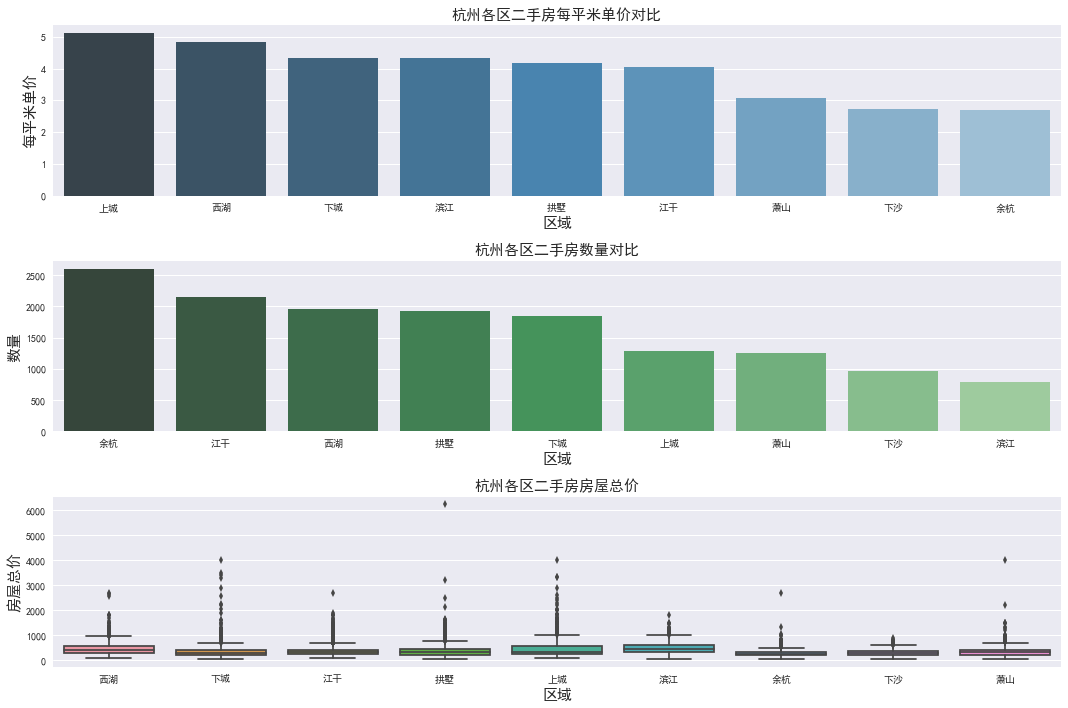

In [73]:
#这两行代码也可参考拉勾网那个项目里的，count之后，用pd.DataFrame将其存入，与此达到的效果一样
df_house_count = df.groupby('Region')['Price'].count().sort_values(ascending=False).to_frame().reset_index()
#df_house_count = df['Price'].groupby(df['Region']).count().sort_values(ascending=False).to_frame().reset_index()
#x效果和上面一样
df_house_mean = df.groupby('Region')['PerPrice'].mean().sort_values(ascending=False).to_frame().reset_index()
#print (df_house_count)

f, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=(15,10))
sns.barplot(x='Region', y='PerPrice', palette="Blues_d", data=df_house_mean, ax=ax1)
ax1.set_title('杭州各区二手房每平米单价对比',fontsize=15)
ax1.set_xlabel('区域',fontsize=15)
ax1.set_ylabel('每平米单价',fontsize=15)

sns.barplot(x='Region', y='Price', palette="Greens_d", data=df_house_count, ax=ax2)
ax2.set_title('杭州各区二手房数量对比',fontsize=15)
ax2.set_xlabel('区域',fontsize=15)
ax2.set_ylabel('数量',fontsize=15)

sns.boxplot(x='Region', y='Price', data=df, ax=ax3)
ax3.set_title('杭州各区二手房房屋总价',fontsize=15)
ax3.set_xlabel('区域',fontsize=15)
ax3.set_ylabel('房屋总价',fontsize=15)
plt.tight_layout()
plt.show()

使用了pandas的网络透视功能groupby来分组，然后用seaborn完成区域特征的可视化，颜色使用调色板 palette 参数，颜色渐变，越浅说明越少，反之越多。
可以观察到：
 （1）二手房价单价：上城区的单价最贵，大约在5万多一平，其次是西湖区
 （2）二手房数量：余杭区的二手房数量遥遥领先，有2000多套。
 （3）二手房总价：通过箱型图看到，各大区域房屋总价中位数都都在1000万以下，而拱墅区有一个明显的值，总价在6000万以上，这到底是异常值呢，还是面积较大，这个有待下一步探讨

In [90]:
df.loc[df['Price']>6000]

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year,Size_new,PerPrice
7067,南,湖墅,有电梯,21,武林壹号,103102602643,5室2厅,6236.0,拱墅,其他,556.79,2015.0,556.79,11.199914


这个总价大于6000万的房子房屋的面积有500多平且单价娇贵，可能是一个高档的写字楼之类的，暂且看不出来是异常值

（2）Size特征值分析

In [94]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(15, 5))
# 建房时间的分布情况
sns.distplot(df['Size_new'], ax=ax1, color='r')
sns.kdeplot(df['Size_new'], shade=True, ax=ax1)
# 建房时间和出售价格的关系
sns.regplot(x='Size_new', y='Price', data=df, ax=ax2)
plt.tight_layout()
plt.show()

D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
D:\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


ValueError: cannot convert float NaN to integer

前面我们在进行Size处理的时候，异常值都填补为空值，观察Size的空值有61行，不算太多，因为Size值无法预估，所以我们将这些行删除

In [114]:
l=df.loc[df['Size_new'].isnull()]
for i in l.index:
    df.drop([i],axis=0,inplace=True)
df.loc[df['Size_new'].isnull()]

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year,Size_new,PerPrice


即已经将Size_new为空值的行删除掉了

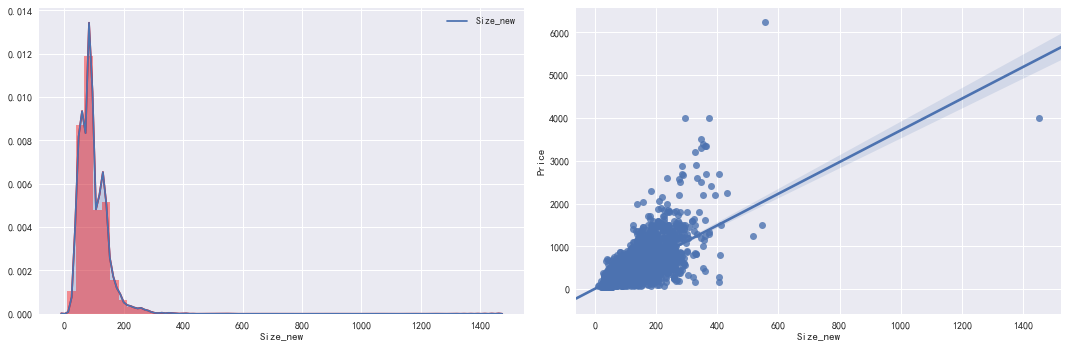

In [116]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(15, 5))
# 建房时间的分布情况
sns.distplot(df['Size_new'], ax=ax1, color='r')
sns.kdeplot(df['Size_new'], shade=True, ax=ax1)
# 建房时间和出售价格的关系
sns.regplot(x='Size_new', y='Price', data=df, ax=ax2)
plt.tight_layout()
plt.show()

由图像观察，基本在正常范围内

（3）Layout特征分析

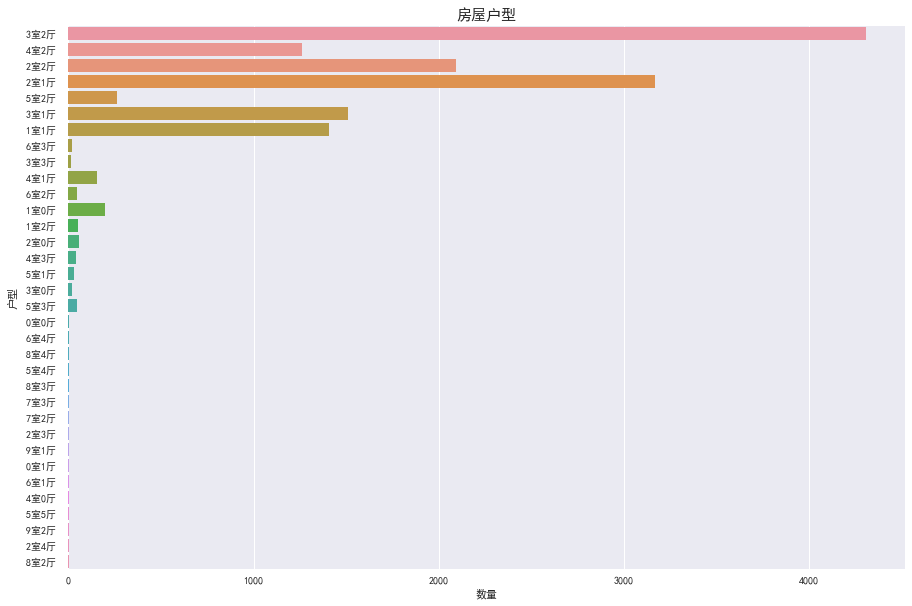

In [121]:
f, ax1= plt.subplots(figsize=(15,10))
sns.countplot(y='Layout', data=df, ax=ax1)
ax1.set_title('房屋户型',fontsize=15)
ax1.set_xlabel('数量')
ax1.set_ylabel('户型')
plt.show()

对于layout可以看到3室2厅的房屋构造是最多的，其次是4室2厅

(4)Renovation特征分析

In [159]:
a=df.groupby('Renovation').size()
a

Renovation
 其他      293
 其他     1270
 毛坯      459
 毛坯     1134
 简装      433
 简装     4905
 精装      708
 精装     5510
dtype: int64

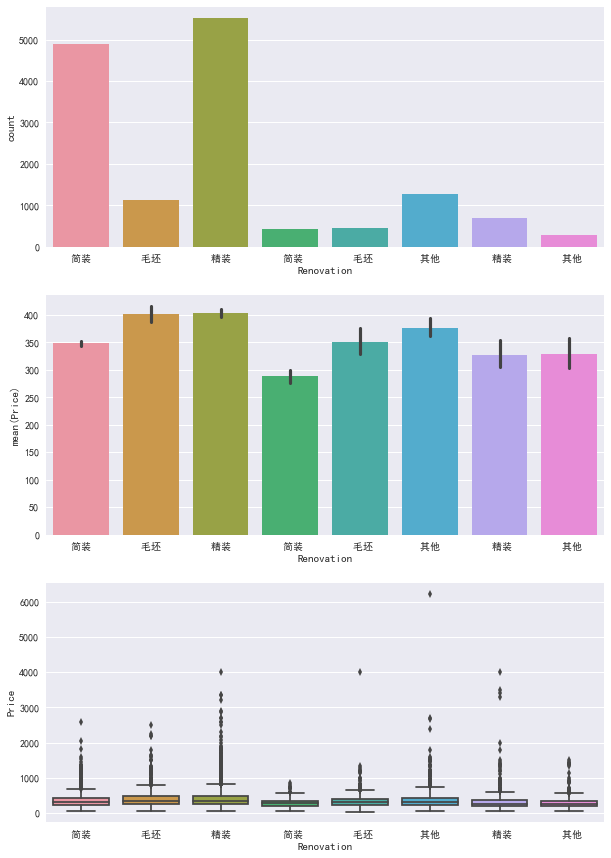

In [163]:
f, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(10, 15))
sns.countplot(df['Renovation'], ax=ax1)
sns.barplot(x='Renovation', y='Price', data=df, ax=ax2)
sns.boxplot(x='Renovation', y='Price', data=df, ax=ax3)
plt.show()

(5)Elevator特征分析

最开始的时候我们就已经发现Elevator特征有大量缺失值，这对于我们的数据分析是很不利的，首先我们看看有多少缺失值

In [164]:
misn = len(df.loc[(df['Elevator'].isnull()), 'Elevator'])
print('Elevator缺失值数量为：'+ str(misn))

Elevator缺失值数量为：1893


这里有很多缺失值，所以要做一些处理，这里我们考虑填补法，但是有无电梯不是数值，我们一致认为大于六层就有电梯，而小于等于6层一般就没有电梯，我们按这个标准来填充。

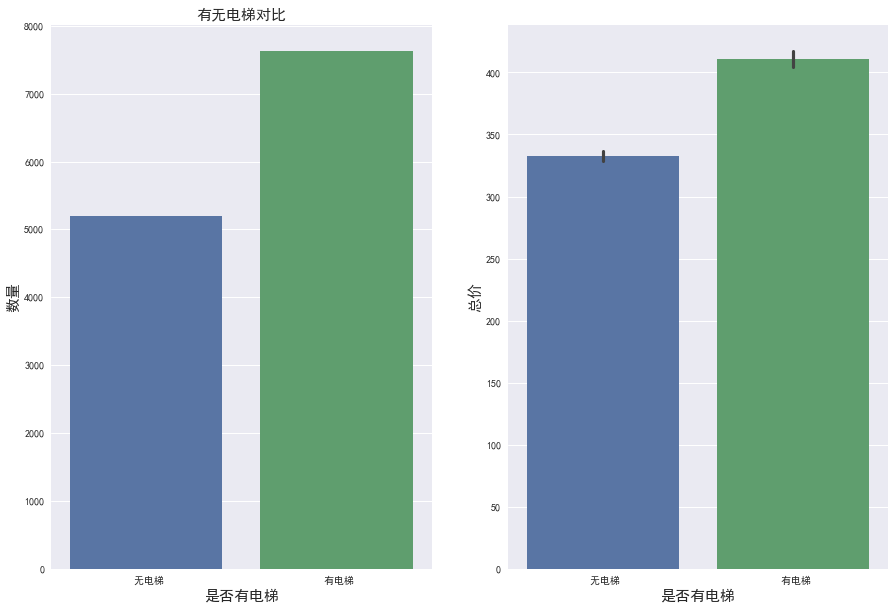

In [173]:
df.loc[(df['Floor']>6)%df['Elevator'].isnull(),'Elevator']=='有电梯'
df.loc[(df['Floor']<=6)%df['Elevator'].isnull(),'Elevator']=='无电梯'
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(15, 10))
sns.countplot(df['Elevator'],ax=ax1)
ax1.set_title('有无电梯对比',fontsize=15)
ax1.set_xlabel('是否有电梯',fontsize=15)
ax1.set_ylabel('数量',fontsize=15)
sns.barplot(x='Elevator',y='Price',data=df,ax=ax2)
ax2.set_xlabel('是否有电梯',fontsize=15)
ax2.set_ylabel('总价',fontsize=15)
plt.show()

结果观察到，有电梯的二手房数量居多一些，毕竟高层土地利用率比较高，而高层就需要电梯。相应的，有电梯二手房房价较高，因为电梯前期装修费和后期维护费包含内了（但这个价格比较只是一个平均的概念，比如无电梯的6层豪华小区当然价格更高了）。

（6）Year特征值分析

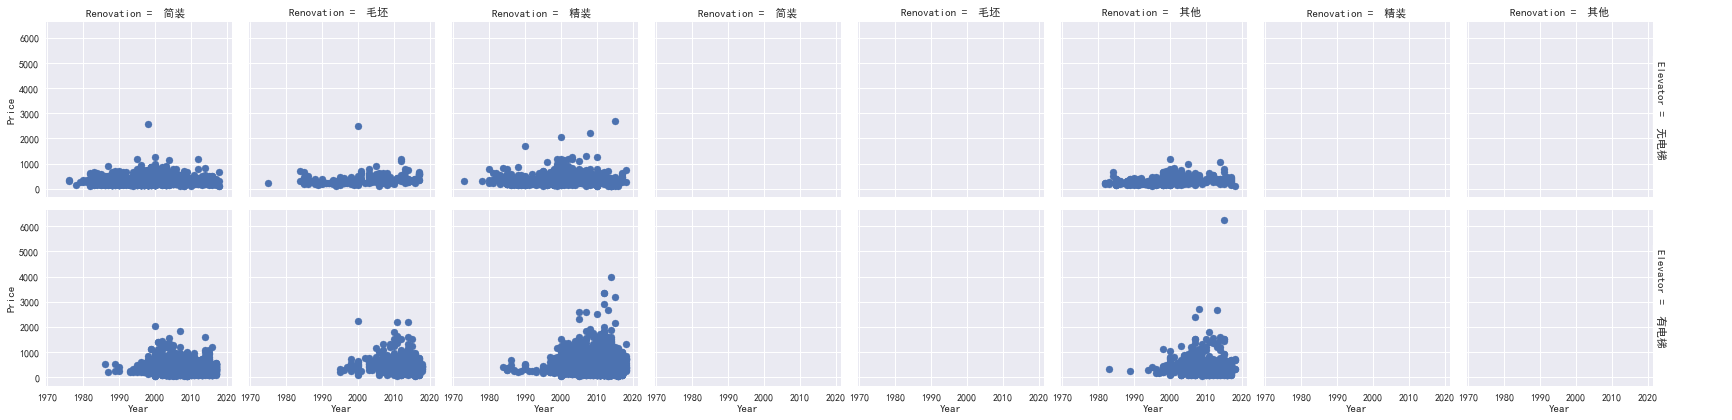

In [177]:
grid = sns.FacetGrid(df, row='Elevator', col='Renovation', palette='seismic',margin_titles=True)
grid.map(plt.scatter, 'Year', 'Price')
grid.add_legend()
plt.show()

在Renovation和Elevator的分类条件下，使用FaveGrid分析Year特征，观察结果如下：
    - 整个二手房房价是随着时间增长而增长的；
    - 1980年之前几乎不存在电梯二手房数据，说明1980之前还没有大面积安装电梯；
    - 1980年之前无电梯二手房中，简装二手房占绝大多数，精装反而很少